# Calculate and visualize biases of an ICON simulation

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy

## Specify data set

In [3]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_ckdtree_zave = fpath_ckdtree
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [4]:
IcD = pyic.IconData(
               fname        = run+'_????????????????.nc',
               path_data    = path_data,
               path_grid    = path_grid,
               gname        = gname,
               lev          = lev,
               do_triangulation = True,
               omit_last_file   = False
              )

## Load data

After loading the temperature and salinity data, land values are masked. This is important since otherwise there are zero biases over land which leads to too little biases if spatial averages are applied.

In [5]:
# --- specify time step
it = np.argmin(np.abs(IcD.times-np.datetime64('2295-01-01T00:00:00')))

# --- load data
f = Dataset(IcD.flist_ts[it], 'r')
to = f.variables['to'][IcD.its[it],:,:]
so = f.variables['so'][IcD.its[it],:,:]
to[IcD.wet_c==0.]=np.ma.masked
so[IcD.wet_c==0.]=np.ma.masked
f.close()

As reference data, we use the initial data of the simulation (PHC climatology) but any other data set can used here as well.

In [6]:
# --- load reference data
fpath_initial_state = path_data+'initial_state.nc'
f = Dataset(fpath_initial_state, 'r')
temp_ref = f.variables['T'][0,:,:]
salt_ref = f.variables['S'][0,:,:]
temp_ref[IcD.wet_c==0.]=np.ma.masked
salt_ref[IcD.wet_c==0.]=np.ma.masked
f.close()

## Calculate bias

First we calculate the bias at each point in space (3D field):

In [7]:
tbias = to-temp_ref
sbias = so-salt_ref

Note dimension of the fields:

In [8]:
tbias.shape

(64, 235403)

In the following, we will apply different averages of the biases and visualize them.

## Horizontally averaged bias

For a horizontally averaged bias, we need to multiply each local value with the local area, performa a horizontal sum, and finally divide by the total area of water values at that depth level (note that ``total_area`` is a profile depending on depth).

In [9]:
total_area = (IcD.wet_c*IcD.cell_area[np.newaxis,:]).sum(axis=1)

tbias_have = (tbias*IcD.cell_area[np.newaxis,:]).sum(axis=1)/total_area
sbias_have = (sbias*IcD.cell_area[np.newaxis,:]).sum(axis=1)/total_area

Plotting the profiles:

<IPython.core.display.Javascript object>


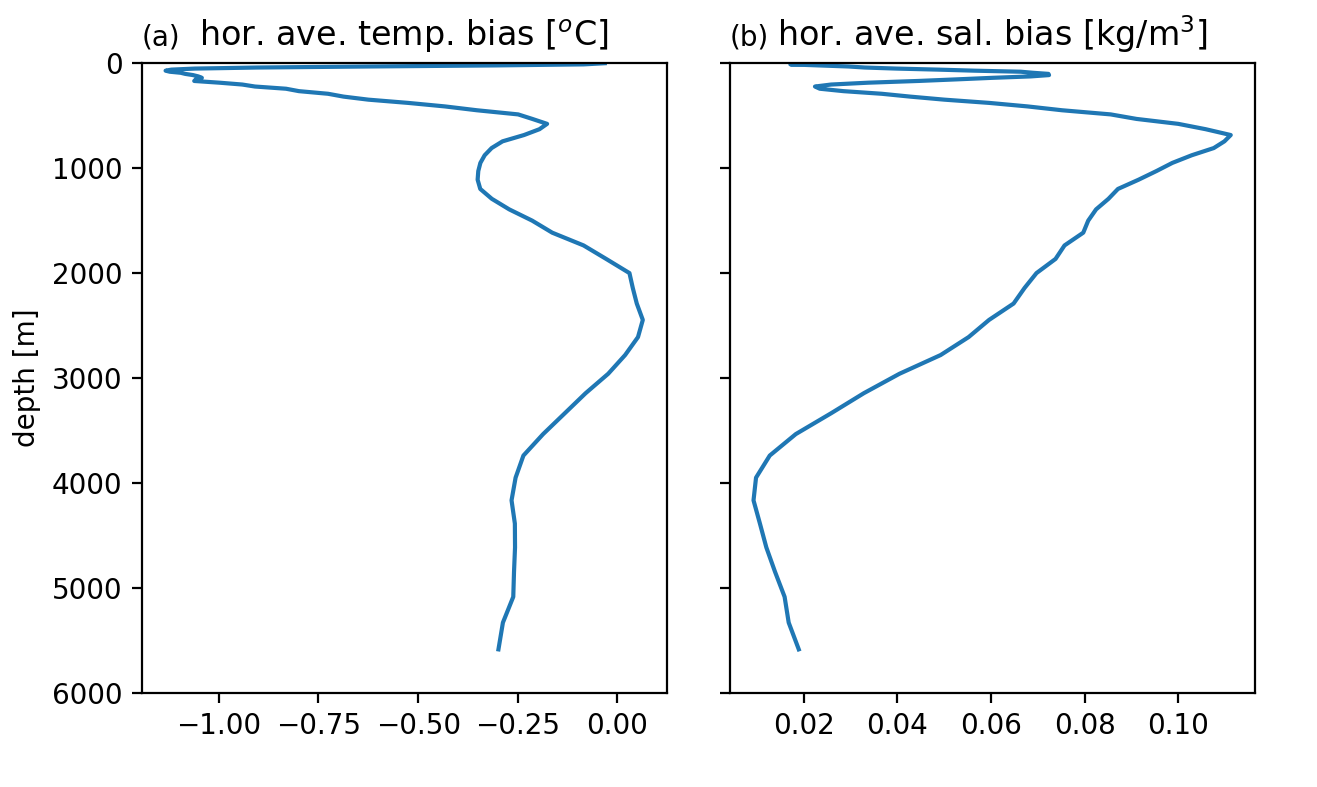

In [10]:
hca, hcb = pyic.arrange_axes(2,1, plot_cb=False, asp=1.2, fig_size_fac=2.,
                           sharex=False, sharey=True,
                           xlabel="", ylabel="depth [m]",
                          )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(tbias_have, IcD.depthc)
ax.set_title('hor. ave. temp. bias [$^o$C]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
ax.plot(sbias_have, IcD.depthc)
ax.set_title('hor. ave. sal. bias [kg/m$^3$]')

for ax in hca:
  ax.set_ylim(6000,0)

## Zonally averaged bias

Zonal averages can be applied by using the ``pyicon`` function ``zonal_average_3d_data``. While it is also possible to apply averages over the Atlantic, Pacific or Indo-Pacifi only, we only use a global average here:

In [11]:
lat_sec, tbias_gzave = pyic.zonal_average_3d_data(tbias, basin='global',
                         fpath_fx=IcD.fpath_fx, fpath_ckdtree=fpath_ckdtree_zave)
lat_sec, sbias_gzave = pyic.zonal_average_3d_data(sbias, basin='global',
                         fpath_fx=IcD.fpath_fx, fpath_ckdtree=fpath_ckdtree_zave)

Plotting the zonally averaged biases:

<IPython.core.display.Javascript object>


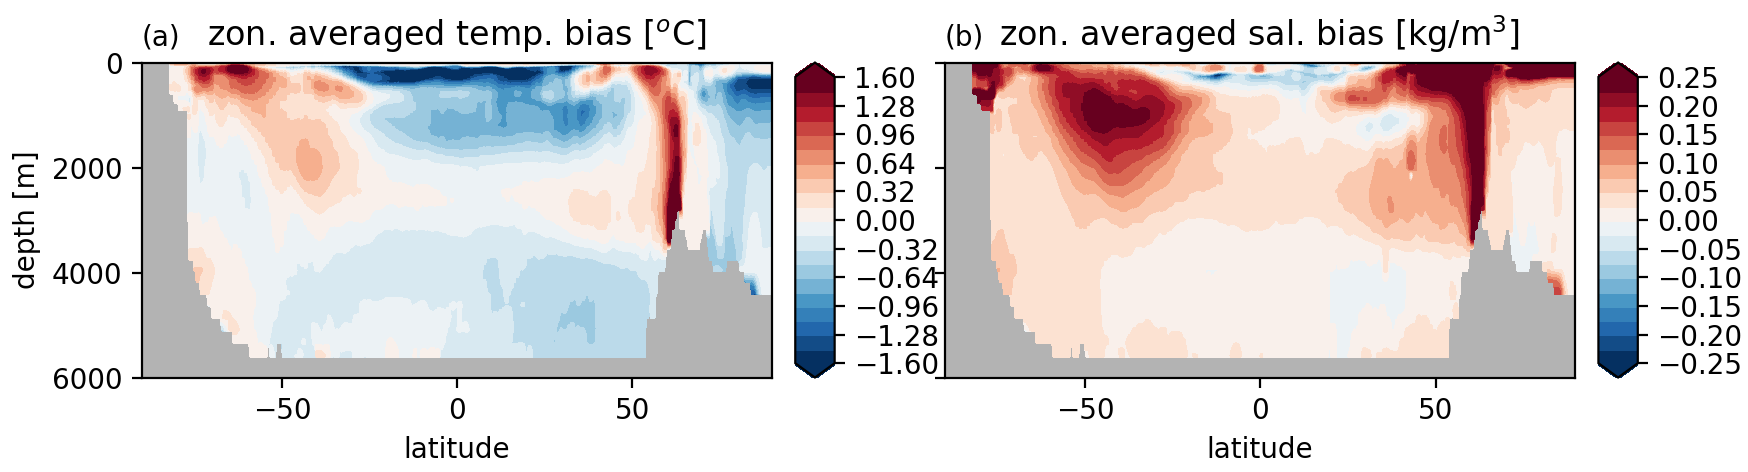

In [12]:
hca, hcb = pyic.arrange_axes(2,1, plot_cb=True, asp=0.5, fig_size_fac=1.,
                             #f_dcbr=1.3,
                             sharex=True, sharey=True,
                             xlabel="latitude", ylabel="depth [m]",
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat_sec, IcD.depthc, tbias_gzave, ax=ax, cax=cax,
                  clim=1.6, cincr=0.16, contfs='auto')
ax.set_title('zon. averaged temp. bias [$^o$C]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat_sec, IcD.depthc, sbias_gzave, ax=ax, cax=cax,
                  clim=0.25, cincr=0.025, contfs='auto')
ax.set_title('zon. averaged sal. bias [kg/m$^3$]')

for ax in hca:
  ax.set_facecolor('0.7')
  ax.set_ylim(6000,0)

## Vertically averaged bias

To calculate the vertically averaged biases, we first define the bins inbetween which the averages should be calculated:

In [13]:
# ------ define depth levels in between which biases should be averaged
levs = np.array([0,250,500,3000,6000])

In the following, we will interpolate the vertically averaged fields to a rectangular grid specified by ``fpath_ckdtree``. Therefore, we need the dimension of this grid which is why we load the rectangular grid file first after allocating the variables:

In [14]:
# ------ allocate variables
ddnpz = np.load(fpath_ckdtree)
tbias_vavei = np.zeros((levs.size, ddnpz['lat'].size, ddnpz['lon'].size))
sbias_vavei = np.zeros((levs.size, ddnpz['lat'].size, ddnpz['lon'].size))

Now, we loop over all layers and average the biases in between the layers. Directly after calculating the vertical average, it will be interpolated to the rectangular grid.

In [15]:
# ------ loop over layers, average bias and interpolate to rectgrid
for nn in range(len(levs)-1):
  iz1 = np.argmin((IcD.depthc-levs[nn])**2)
  iz2 = np.argmin((IcD.depthc-levs[nn+1])**2)
  # ------ temperature
  bias_vave = ((tbias*IcD.dzw)[iz1:iz2,:]).sum(axis=0)/(IcD.dzw[iz1:iz2,:].sum(axis=0)+1e-33)
  lon, lat, tbias_vavei[nn,:,:] = pyic.interp_to_rectgrid(bias_vave, fpath_ckdtree)
  # ------ salinity
  bias_vave = ((sbias*IcD.dzw)[iz1:iz2,:]).sum(axis=0)/(IcD.dzw[iz1:iz2,:].sum(axis=0)+1e-33)
  lon, lat, sbias_vavei[nn,:,:] = pyic.interp_to_rectgrid(bias_vave, fpath_ckdtree)

Finally, we make the plots:

<IPython.core.display.Javascript object>


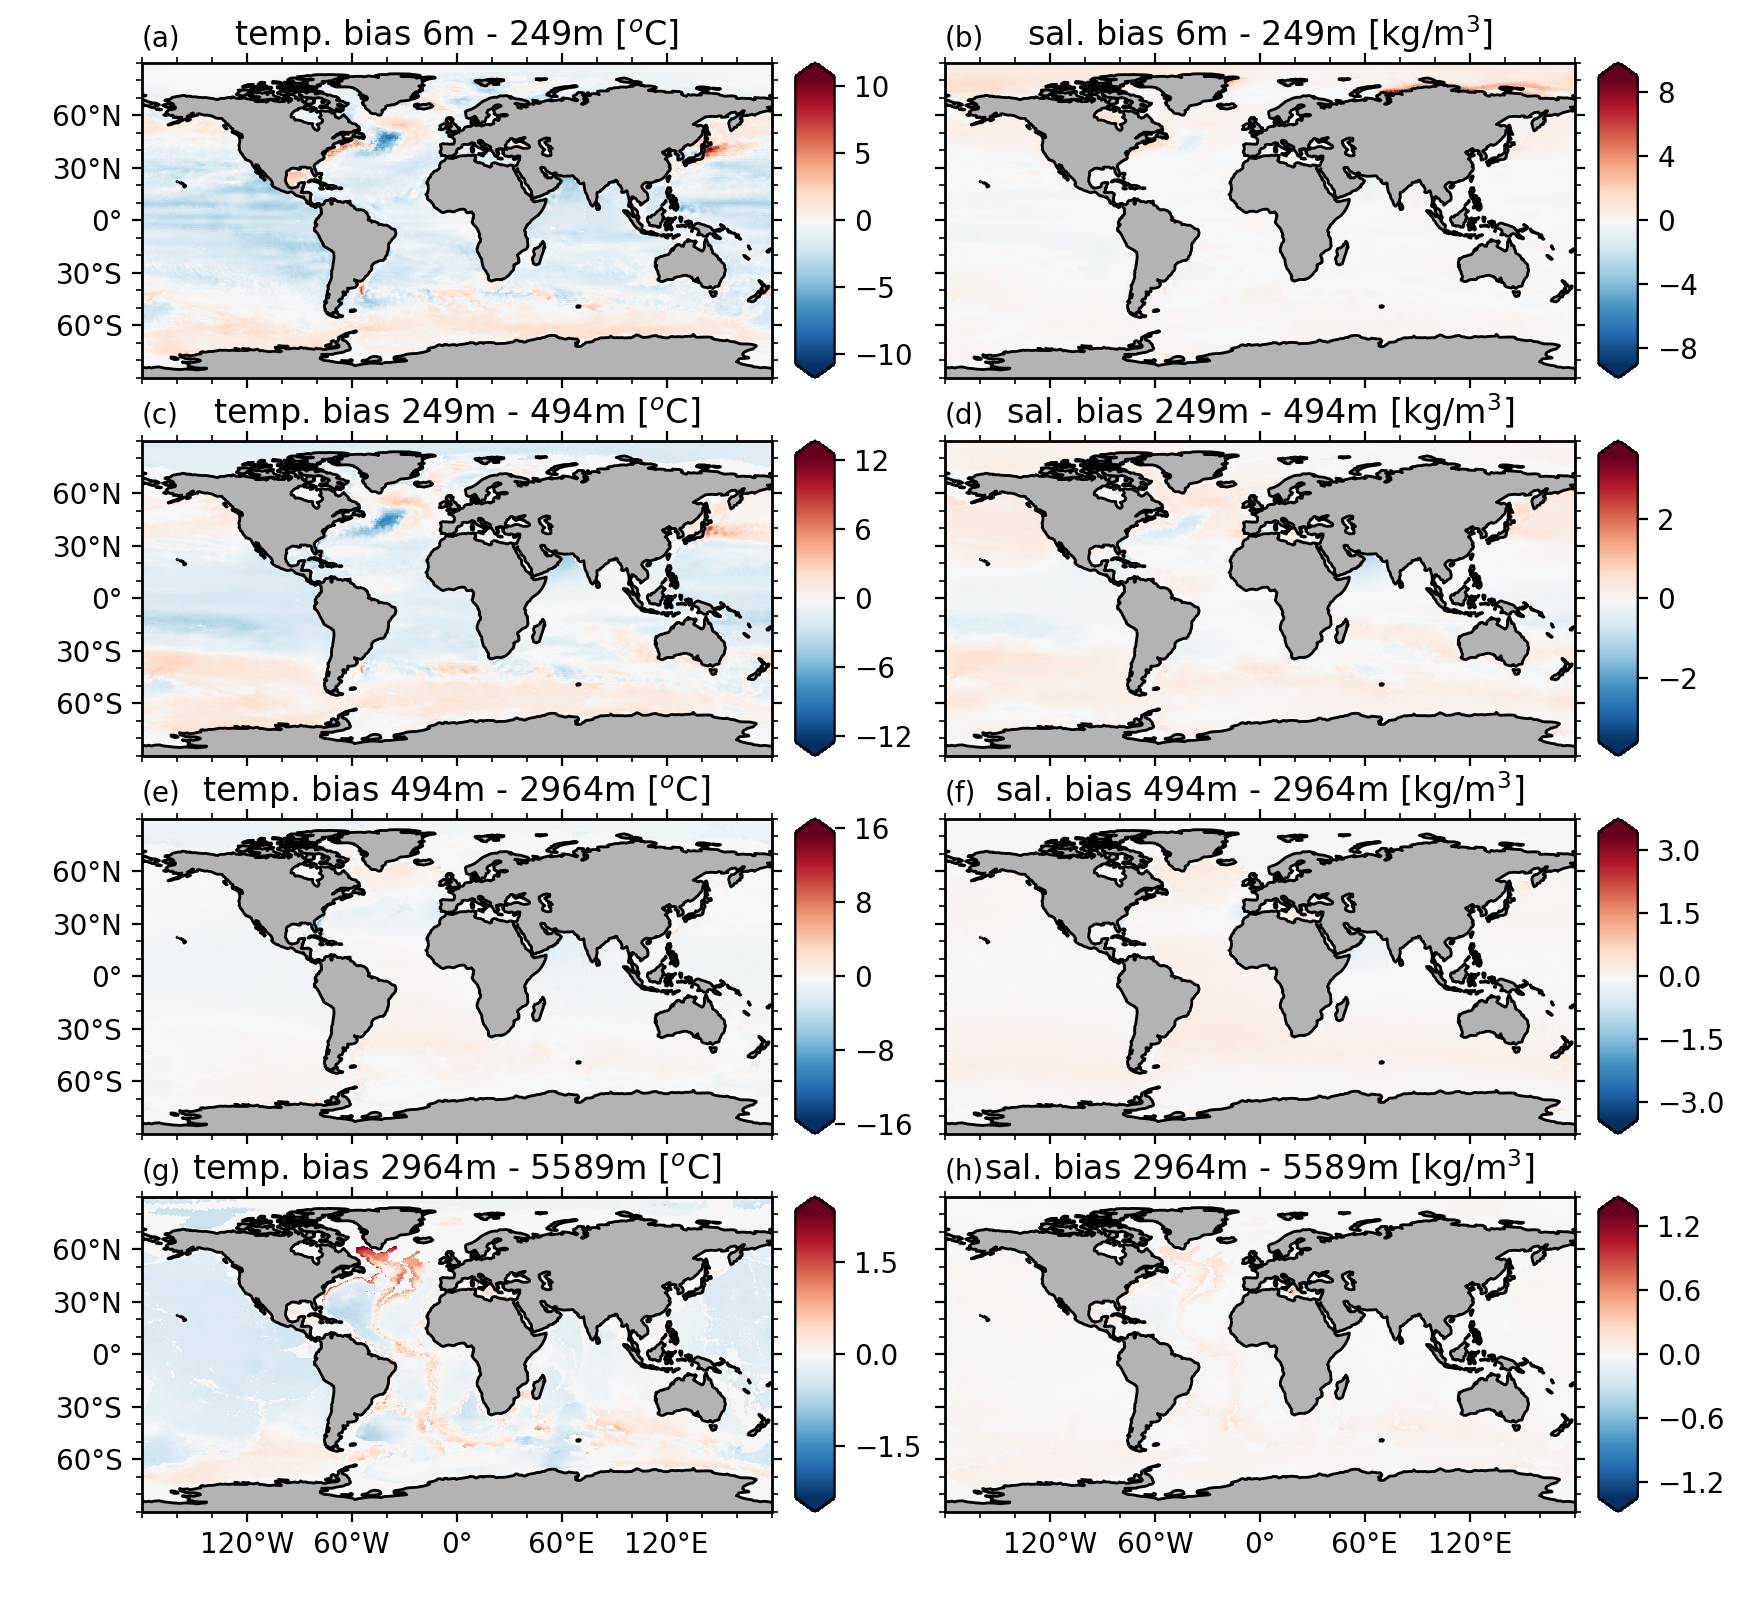

In [16]:
ccrs_proj = cartopy.crs.PlateCarree()
hca, hcb = pyic.arrange_axes(2,4, plot_cb=True, asp=0.5, fig_size_fac=1.,
                           sharex=True, sharey=True,
                           xlabel="", ylabel="",
                           projection=ccrs_proj,
                          )
ii=-1

nn = 0

climT = ['sym']*(levs.size-1)
climS = ['sym']*(levs.size-1)

# --- temperature
for nn in range(levs.size-1):
  iz1 = np.argmin((IcD.depthc-levs[nn])**2)
  iz2 = np.argmin((IcD.depthc-levs[nn+1])**2)

  ii+=1; ax=hca[ii]; cax=hcb[ii]
  hm = pyic.shade(lon, lat, tbias_vavei[nn,:,:], ax=ax, cax=cax, clim=climT[nn],
                  transform=ccrs_proj)
  ax.set_title('temp. bias %.fm - %.fm [$^o$C]'%(IcD.depthc[iz1],IcD.depthc[iz2]))
  pyic.plot_settings(ax, projection=ccrs_proj, template='global')

# --- salinity
#for nn in range(levs.size-1):
  iz1 = np.argmin((IcD.depthc-levs[nn])**2)
  iz2 = np.argmin((IcD.depthc-levs[nn+1])**2)

  ii+=1; ax=hca[ii]; cax=hcb[ii]
  hm = pyic.shade(lon, lat, sbias_vavei[nn,:,:], ax=ax, cax=cax, clim=climS[nn],
                  transform=ccrs_proj)
  ax.set_title('sal. bias %.fm - %.fm [kg/m$^3$]'%(IcD.depthc[iz1],IcD.depthc[iz2]))
  pyic.plot_settings(ax, projection=ccrs_proj, template='global')